In [2]:
import re
import gzip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


from termcolor import colored


In [5]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')



In [6]:
beauty_df=getDF('./reviews_Beauty_5.json.gz')

In [7]:
grocery_df=getDF('./reviews_Grocery_and_Gourmet_Food_5.json.gz')

In [8]:
beauty_df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


In [9]:
office_df=getDF("./reviews_Office_Products_5.json.gz")

In [10]:
pet_df=getDF("./reviews_Pet_Supplies_5.json.gz")

In [11]:
toy_df=getDF("./reviews_Toys_and_Games_5.json.gz")

In [12]:
beauty_df=beauty_df[["reviewText","overall"]]
beauty_df["category"]="beauty"

grocery_df=grocery_df[["reviewText","overall"]]
grocery_df["category"]="grocery"

office_df=office_df[["reviewText","overall"]]
office_df["category"]="office"

pet_df=pet_df[["reviewText","overall"]]
pet_df["category"]="pet"

toy_df=toy_df[["reviewText","overall"]]
toy_df["category"]="toy"


In [13]:
grocery_df.head(2)

,reviewText,overall,category
0,Just another flavor of Kit Kat but the taste i...,4.0,grocery
1,I bought this on impulse and it comes from Jap...,3.0,grocery


In [14]:
data=pd.concat([beauty_df,grocery_df,office_df,pet_df,toy_df])

In [15]:
print(colored("Total length of data","red"),colored(len(data),"green"))

Total length of data 728447


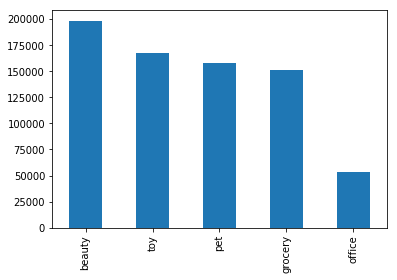

In [16]:
data["category"].value_counts().plot(kind="bar");

In [17]:
data.drop_duplicates(inplace=True)

In [18]:
data.dropna(inplace=True)

In [19]:
len(data)

728053

In [20]:
data=data.groupby("category").head(10000)

In [21]:
len(data)

50000

# Data Cleaning

In [22]:
import string
from nltk.tokenize import word_tokenize as tokenize
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

In [23]:
def clean(text):
    text=text.lower()
    url_removed=re.sub(r'http\S+','',text,flags=re.MULTILINE)
    text=re.sub("[^a-zA-Z]"," ",url_removed)
    text=re.sub("\.+"," ",text)
    word_tokens=tokenize(text)
    text=[word for word in word_tokens if word not in stop_words]
    text=[word for word in text if word not in string.punctuation]
    return " ".join(text)

In [24]:
clean("this is good. day 000 !!!! Is it &")

'good day'

In [25]:
check=data["reviewText"].iloc[0]

In [26]:
print("original sentence",check)

original sentence Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.


In [27]:
print("cleaned sentence",clean(check))

cleaned sentence oily creamy expected ordered try highlight contour looked awful plus took forever arrive


In [28]:
data["cleaned_text"]=data["reviewText"].apply(lambda x:clean(x))

In [29]:
data.head(5)

,reviewText,overall,category,cleaned_text
0,Very oily and creamy. Not at all what I expect...,1.0,beauty,oily creamy expected ordered try highlight con...
1,This palette was a decent price and I was look...,3.0,beauty,palette decent price looking different shades ...
2,The texture of this concealer pallet is fantas...,4.0,beauty,texture concealer pallet fantastic great cover...
3,I really can't tell what exactly this thing is...,2.0,beauty,really tell exactly thing powder kind oil ish ...
4,"It was a little smaller than I expected, but t...",3.0,beauty,little smaller expected okay lasted long time ...


In [14]:
category_labels={"beauty":0,"grocery":1,"office":2,"pet":3,"toy":4}
data["label"]=data["category"].map(category_labels)

NameError: name 'data' is not defined

In [31]:
data.head(5)

,reviewText,overall,category,cleaned_text,label
0,Very oily and creamy. Not at all what I expect...,1.0,beauty,oily creamy expected ordered try highlight con...,0
1,This palette was a decent price and I was look...,3.0,beauty,palette decent price looking different shades ...,0
2,The texture of this concealer pallet is fantas...,4.0,beauty,texture concealer pallet fantastic great cover...,0
3,I really can't tell what exactly this thing is...,2.0,beauty,really tell exactly thing powder kind oil ish ...,0
4,"It was a little smaller than I expected, but t...",3.0,beauty,little smaller expected okay lasted long time ...,0


In [32]:
data=data[["cleaned_text","label"]]

In [33]:
data.head(2)

,cleaned_text,label
0,oily creamy expected ordered try highlight con...,0
1,palette decent price looking different shades ...,0


In [34]:
type(data["label"].iloc[0])

numpy.int64

In [35]:
data["label"]=data["label"].astype(int)

In [36]:
data["len"]=data["cleaned_text"].apply(lambda x:len(x.split()))

In [37]:
max(data["len"])

1155

In [38]:
min(data["len"])

0

In [39]:
data=data[data["len"]>=1]

In [40]:
type(data["label"].iloc[0])

numpy.int64

In [41]:
data["label"].value_counts()

3    9999
1    9998
4    9997
2    9997
0    9997
Name: label, dtype: int64

In [42]:
train_samples_class_0=data[data["label"]==0][:9000]
train_samples_class_1=data[data["label"]==1][:9000]
train_samples_class_2=data[data["label"]==2][:9000]
train_samples_class_3=data[data["label"]==3][:9000]
train_samples_class_4=data[data["label"]==4][:9000]

In [43]:
test_samples_class_0=data[data["label"]==0][9000:]
test_samples_class_1=data[data["label"]==1][9000:]
test_samples_class_2=data[data["label"]==2][9000:]
test_samples_class_3=data[data["label"]==3][9000:]
test_samples_class_4=data[data["label"]==4][9000:]

In [44]:
train=pd.concat([train_samples_class_0,train_samples_class_1,train_samples_class_2,train_samples_class_3,train_samples_class_4])

In [45]:
test=pd.concat([test_samples_class_0,test_samples_class_1,test_samples_class_2,test_samples_class_3,test_samples_class_4])

In [46]:
len(train)

45000

In [47]:
len(test)

4988

In [48]:
train=train.sample(frac=1.0)

In [49]:
test=test.sample(frac=1.0)

In [50]:
train.dropna(subset=["cleaned_text"],inplace=True)

In [51]:
test.dropna(subset=["cleaned_text"],inplace=True)

In [52]:
print("length of train",len(train))
print("length of test",len(test))

length of train 45000
length of test 4988


In [53]:
X_train=np.array(train["cleaned_text"])
X_test=np.array(test["cleaned_text"])
y_train=np.array(train["label"])
y_test=np.array(test["label"])

# Data Preprocessing

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential

In [55]:
tokenizer=Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index

In [56]:
len(word_index)

45586

In [57]:
vocab_size=len(word_index)+1
print(vocab_size)

45587


(array([16619., 15260.,  7274.,  4026.,  2288.,  1376.,   954.,   633.,
          405.,   282.]),
 array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.]),
 <a list of 10 Patch objects>)

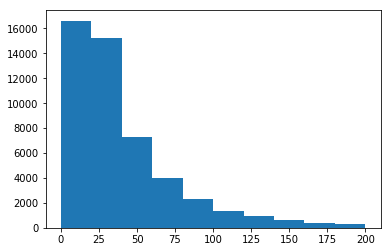

In [58]:
plt.hist(data["len"],range=(0,200))

In [59]:
max_length1 = 80

trunc_type='post'
padding_type='post'


In [60]:
max_length1

80

In [61]:
train_sequences=tokenizer.texts_to_sequences(X_train)


In [62]:
print(X_train[0])
print(train_sequences[0])
print(len(train_sequences[0]))

african grey two dwarf macaws perfect size whatever reason find local pet stores even though smaller larger sizes everywhere happy find seller even happier got within hours ordering parrots happy means happy absolutely order seller
[3087, 1656, 32, 6288, 20533, 111, 102, 727, 373, 52, 388, 475, 427, 20, 87, 350, 395, 1205, 1470, 172, 52, 1325, 20, 2236, 51, 455, 289, 869, 7943, 172, 536, 172, 423, 187, 1325]
35


In [63]:
test_sequences=tokenizer.texts_to_sequences(X_test)
print(test_sequences[0])
print(len(test_sequences[0]))

[277, 38, 385, 2708, 419, 364, 14, 64, 554, 14794, 321, 2468, 14423, 370, 16697, 11596, 591, 21845, 5277, 2420, 732, 2352, 488, 1292, 567, 614, 3264, 118, 14423, 580, 1620, 328, 1057, 1373, 43, 4315, 119, 667, 110, 383, 474, 181, 538, 1373, 722, 30749, 414, 202, 43, 314, 2, 590, 1131, 23, 3972, 752, 3148, 149, 1057, 1248, 22, 5, 1313, 2468, 14423, 737, 220, 372, 20168, 15754, 20168, 15754, 2232, 147, 50, 306, 800, 1580, 3985, 6, 756, 526, 1241, 537, 531, 1090, 950, 43, 34841, 1057, 23, 46, 177, 171, 24, 78, 730, 1729, 227, 177, 1077, 277, 264, 645, 157, 1131, 667, 590, 50, 1057, 46, 1248, 17, 2493, 1215, 149, 701, 275, 8344, 277, 14, 16, 48, 4497, 413, 2326, 104, 705, 11, 18, 2468, 14423, 4, 1057, 1061, 372, 1, 1294, 4, 590, 1131, 72, 1391, 1061, 3148, 15, 430, 1109, 8, 15713, 227, 12525, 5550, 8203, 1109, 17, 121, 140, 228, 277, 319]
161


In [65]:
train_padded=pad_sequences(train_sequences,maxlen=80,padding='post',truncating='post')

In [66]:
test_padded=pad_sequences(test_sequences,maxlen=80,padding="post",truncating="post")

In [67]:
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])

In [68]:
reverse_word_index[101]

'face'

In [69]:
def decode_sentence(text):
    return " ".join([reverse_word_index.get(i,'?') for i in text])
    

In [70]:
vocab_size

45587

In [71]:
embedding_dim=300

In [72]:
embedding_dim

300

In [86]:
lstm_model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.LSTM(128),
#     tf.keras.layers.Dense(20,activation='relu')
    tf.keras.layers.Dense(5,activation='softmax')
])

In [87]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         13676100  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 13,896,393
Trainable params: 13,896,393
Non-trainable params: 0
_________________________________________________________________


In [89]:
opt=tf.keras.optimizers.Adam(0.01)
lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
num_epochs=5
history=lstm_model.fit(train_padded,y_train,epochs=num_epochs,validation_data=(test_padded,y_test),verbose=2)

Epoch 1/5
1407/1407 - 601s - loss: 0.5450 - accuracy: 0.7892 - val_loss: 0.3975 - val_accuracy: 0.8739
Epoch 2/5
1407/1407 - 538s - loss: 0.2133 - accuracy: 0.9316 - val_loss: 0.3824 - val_accuracy: 0.8823
Epoch 3/5
1407/1407 - 531s - loss: 0.1829 - accuracy: 0.9409 - val_loss: 0.4068 - val_accuracy: 0.8751
Epoch 4/5
1407/1407 - 528s - loss: 0.1663 - accuracy: 0.9468 - val_loss: 0.3756 - val_accuracy: 0.8885
Epoch 5/5
1407/1407 - 518s - loss: 0.1499 - accuracy: 0.9523 - val_loss: 0.4010 - val_accuracy: 0.8793


In [96]:
lstm_model.save("lstm_model.h5")

In [91]:
lstm_model2=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(20,activation='relu'),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [92]:
opt=tf.keras.optimizers.Adam(0.01)
lstm_model2.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
num_epochs=5
history=lstm_model2.fit(train_padded,y_train,epochs=num_epochs,validation_data=(test_padded,y_test),verbose=2)

Epoch 1/5
1407/1407 - 535s - loss: 1.6116 - accuracy: 0.1997 - val_loss: 1.6074 - val_accuracy: 0.2119
Epoch 2/5
1407/1407 - 515s - loss: 1.6108 - accuracy: 0.1986 - val_loss: 1.6087 - val_accuracy: 0.2033
Epoch 3/5
1407/1407 - 525s - loss: 1.5772 - accuracy: 0.2355 - val_loss: 1.4152 - val_accuracy: 0.3142
Epoch 4/5
1407/1407 - 526s - loss: 1.2407 - accuracy: 0.3747 - val_loss: 1.1708 - val_accuracy: 0.4579
Epoch 5/5
1407/1407 - 531s - loss: 1.0971 - accuracy: 0.4597 - val_loss: 1.1206 - val_accuracy: 0.4775


In [94]:
bidirectionallstm_model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     tf.keras.layers.Dense(20,activation='relu')
    tf.keras.layers.Dense(5,activation='softmax')
])

In [95]:
opt=tf.keras.optimizers.Adam(0.01)
bidirectionallstm_model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
num_epochs=5
history=bidirectionallstm_model.fit(train_padded,y_train,epochs=num_epochs,validation_data=(test_padded,y_test),verbose=2)

Epoch 1/5
1407/1407 - 541s - loss: 0.2720 - accuracy: 0.9135 - val_loss: 0.3178 - val_accuracy: 0.9086
Epoch 2/5
1407/1407 - 523s - loss: 0.1461 - accuracy: 0.9542 - val_loss: 0.3805 - val_accuracy: 0.8913
Epoch 3/5
1407/1407 - 628s - loss: 0.1371 - accuracy: 0.9575 - val_loss: 0.4076 - val_accuracy: 0.8941
Epoch 4/5
1407/1407 - 619s - loss: 0.1337 - accuracy: 0.9585 - val_loss: 0.4170 - val_accuracy: 0.8889
Epoch 5/5
1407/1407 - 647s - loss: 0.1209 - accuracy: 0.9616 - val_loss: 0.4323 - val_accuracy: 0.8955


In [ ]:
bidirectionallstm_model.save("bilstm_model.h5")

In [1]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'tokenizer' is not defined

In [11]:
with open('/Users/harika/Desktop/NLP_FLASK_APP/models/tokenizer.pickle','rb') as handle:
    loaded_tokenizer=pickle.load(handle)

In [12]:
new_model=tf.keras.models.load_model("./bilstm_model.h5")

In [77]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         13676100  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 14,116,681
Trainable params: 14,116,681
Non-trainable params: 0
_________________________________________________________________


In [17]:
txt={"tea real delight big fan white tea one best varieties tried flavor subtle overpowering get nice peach flavor sweet yet bitter still taste light flavor smooth white tea celestial seasonings imperial white peach white tea one favorite teas see going back time time really pleasant definitely recommend especially love white tea"}
seq=loaded_tokenizer.texts_to_sequences(txt)
padded=pad_sequences(seq,maxlen=80,padding="post",truncating="post")
pred=new_model.predict(padded) # output [ 5 values  for each class and label number]
category_labels={"beauty":0,"grocery":1,"office":2,"pet":3,"toy":4}
labels=list(category_labels.keys())

print(pred,labels[np.argmax(pred)])


[[4.3457326e-06 9.9989617e-01 8.6885484e-05 8.8074676e-06 3.8632879e-06]] grocery


In [18]:
labels[new_model.predict_classes(padded)[0]]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'grocery'

In [89]:
np.max(pred)

0.99989617

In [90]:
np.argmax(pred)

1

In [96]:
labels

['beauty', 'grocery', 'office', 'pet', 'toy']

In [95]:
labels[np.argmax(pred)]

'grocery'

In [91]:
pred

array([[4.3457326e-06, 9.9989617e-01, 8.6885484e-05, 8.8074676e-06,
        3.8632879e-06]], dtype=float32)

In [87]:
from decimal import *
Decimal(4.3457326e-06)*100

Decimal('0.0004345732600000000263513501297')

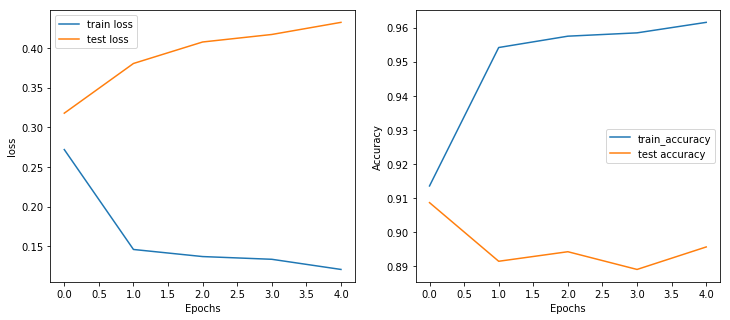

In [98]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss','test loss'])
plt.subplot(122)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy','test accuracy'])
plt.show();

In [101]:
bidirectional_lstm2=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(20,activation='relu')
    tf.keras.layers.Dense(5,activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
opt=tf.keras.optimizers.Adam(0.01)
bidirectional_lstm2.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

history_bilstm = bidirectional_lstm2.fit(train_padded,y_train,epochs=5,validation_data=(test_padded,y_test),callbacks=[callback],verbose=2)

Epoch 1/5
1407/1407 - 581s - loss: 0.2610 - accuracy: 0.9164 - val_loss: 0.2996 - val_accuracy: 0.9048
Epoch 2/5
1407/1407 - 482s - loss: 0.1310 - accuracy: 0.9586 - val_loss: 0.3782 - val_accuracy: 0.8933
Epoch 3/5
1407/1407 - 502s - loss: 0.1151 - accuracy: 0.9632 - val_loss: 0.3996 - val_accuracy: 0.8957
Epoch 4/5
1407/1407 - 484s - loss: 0.1084 - accuracy: 0.9662 - val_loss: 0.4069 - val_accuracy: 0.8901
Epoch 5/5
1407/1407 - 497s - loss: 0.0964 - accuracy: 0.9694 - val_loss: 0.4113 - val_accuracy: 0.8951


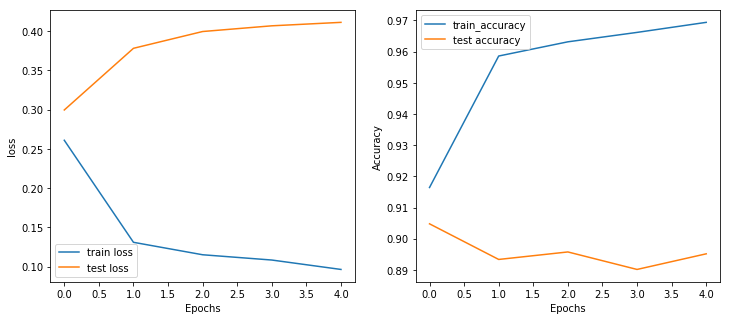

In [102]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss','test loss'])
plt.subplot(122)
plt.plot(history_bilstm.history["accuracy"])
plt.plot(history_bilstm.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy','test accuracy'])
plt.show();

NameError: name 'tokenizer' is not defined